# Massive black hole binary SNR computation

## 0. Useful imports

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import lisaconstants
import scipy.linalg as LA

In [2]:
# Local package
import ldc.waveform.fastGB as fastGB
from ldc.waveform.lisabeta import FastBHB
from ldc.common.series import TDI, XYZ2AET
from ldc.lisa import orbits
from ldc.lisa.noise import get_noise_model
import ldc.io.hdf5 as hdfio
from astropy import units as un
from pyfftw.interfaces.numpy_fft import fft, ifft

In [3]:
YEAR = lisaconstants.SIDEREALYEAR_J2000DAY*24*60*60
CLIGHT = lisaconstants.SPEED_OF_LIGHT

Training file contains the following dataset:
- `sky/cat` with source parameters
- `sky/tdi` with noise free and artifact free TDI (t, X, Y, Z) 4D array
- `obs/tdi` with noise and artifacts
- `noisefree/tdi` with artifacts but noise free TDI
- `clean/tdi` with noise but artifacts free TDI

Additional parameter of the simulation can be found in `instru/config` and `obs/config` and `sky/config`. 

## 1. Loading the MBHB dataset

### 1.1 Get source parameters

In [4]:
# training_file = '/feynman/work/dphp/qb265383/spritz/data/LDC2_spritz_mbhb1_training_v2.h5'
training_file = '/Users/qb265383/Data/ldc/LDC2_spritz_mbhb1_training_v2.h5'
fid = h5py.File(training_file)
names = fid["sky/cat"].dtype.names
cat_vgb = dict(zip(names, [fid["sky/cat"][name] for name in names]))
# print(cat_vgb)
# get units
units = [(k, fid['sky/cat'].attrs.get(k)) for k in names]
units = dict(units)

## 2. Testing the waveform generator

In [5]:
# Set orbit parameters
lisaorbits = orbits.Orbits.type(dict({'orbit_type':'analytic', 'nominal_arm_length':2.5e9, # or cfg["nominal_arm_length"]
                           "initial_position": 0, "initial_rotation": 0}))

In [6]:
mbhb, units = hdfio.load_array(training_file, name="sky/cat")
print(mbhb.dtype.names)
print(mbhb)
pmbhb = {name: mbhb[name] for name in mbhb.dtype.names}

('EclipticLatitude', 'EclipticLongitude', 'PolarAngleOfSpin1', 'PolarAngleOfSpin2', 'Spin1', 'Spin2', 'Mass1', 'Mass2', 'CoalescenceTime', 'PhaseAtCoalescence', 'InitialPolarAngleL', 'InitialAzimuthalAngleL', 'Redshift', 'Distance', 'ObservationDuration', 'Cadence')
(-0.30300442, 1.29251839, 1.20313618, 2.09730354, 0.747377, 0.8388, 1323277.47932, 612485.50603, 11526944.92187926, 1.22019689, 2.69198245, 1.8083985, 1.73941, 13470.98355897, 31558149.7635456, 3.)


### 2.1 With A

In [7]:
tdi_labels = ["X", "Y", "Z"]
fid = h5py.File(training_file)
tdi_sky = fid["sky/tdi"][()].squeeze()
tdi_xyz_sky = np.array([tdi_sky[label].copy()[:] for label in tdi_labels]).T
asky, esky, tsky = XYZ2AET(tdi_sky["X"], tdi_sky["Y"], tdi_sky["Z"])
fid.close()
print(type(tdi_xyz_sky))


<class 'numpy.ndarray'>


In [8]:
tdi_aet_sky = np.array([ch.copy()[:] for ch in [asky, esky, tsky]]).T

In [9]:
tdi_ts = TDI.load(training_file, name="obs/tdi")
# Transform observed data to AET
tdi_ts.XYZ2AET()
# Get maximum time of the series
dt = tdi_ts["A"].attrs["dt"]
tmax = tdi_ts["A"].t[-1] + dt
t0 = tdi_ts["A"].t[0]
# Fix the cadence (even if it seems it is not used)
pmbhb["Cadence"] = dt
# Instantiate waveform
FBH = FastBHB("MBHB", T=tmax.values, 
              delta_t=dt, 
              approx="IMRPhenomD", 
              orbits=lisaorbits)
# Generate TDI response in the time domain for XYZ
xt, yt, zt = FBH.get_td_tdixyz(template=pmbhb, tdi2=True)
XYZ = TDI(dict(zip(["X", "Y", "Z"], [xt, yt, zt])))

In [10]:
# Generate TDI response in the time domain for AET
at, et, tt = FBH.get_td_tdiaet(template=pmbhb, tdi2=True)
AET = TDI(dict(zip(["A", "E", "T"], [at, et, tt])))


In [11]:
# Size of the full time series
size = tdi_aet_sky.shape[0]

Text(0.5, 0, 'time [s]')

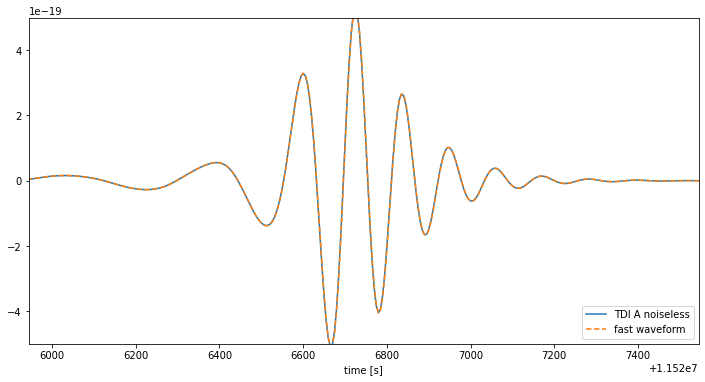

In [12]:
# Plotting the fast approximant over the data
t_vect = tdi_ts["A"].t
plt.figure(figsize=(12,6))
plt.plot(t_vect, tdi_aet_sky[:, 0], label="TDI A noiseless")
plt.plot(t_vect, at[-size:], 
         label="fast waveform", 
         linestyle='dashed')
# plt.plot(t_vect, xt, label="TDI X noiseless")
# XYZ.X.plot(label="fast waveform", linestyle='dashed')
plt.legend(loc="lower right")
plt.axis([pmbhb["CoalescenceTime"]-1000, pmbhb["CoalescenceTime"]+600, -0.5e-18, 0.5e-18])
plt.xlabel("time [s]")

In [13]:
# Fast waveform in the Fourier domain
af, ef, tf = FBH.get_fd_tdiaet(template=pmbhb, tdi2=True)

In [14]:
# Fourier transform the data
a_dft = np.fft.fft(tdi_aet_sky[:, 0]) * dt
f_dft = np.fft.fftfreq(size) / dt
id_pos = np.where(f_dft>0)[0]

In [15]:
# Fourier transform of the time-domain waveform
a_t_dft = np.fft.fft(at[-size:]) * dt

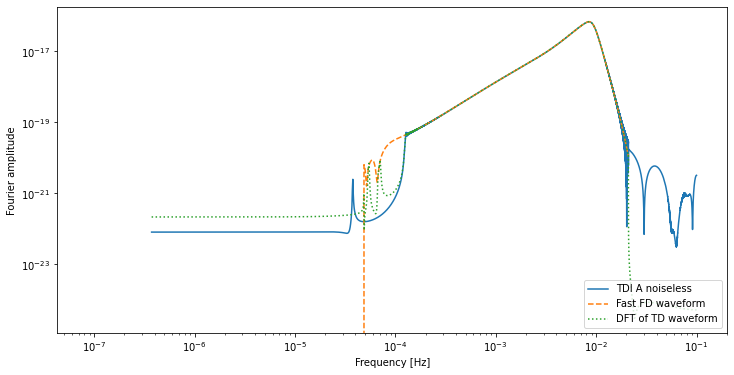

In [16]:
plt.figure(figsize=(12,6))
plt.plot(f_dft[id_pos], np.abs(a_dft[id_pos]), 
         label="TDI A noiseless")
plt.plot(af.f, np.abs(af.values), 
         label="Fast FD waveform", 
         linestyle='dashed')
plt.plot(f_dft[id_pos], np.abs(a_t_dft[id_pos]), 
         label="DFT of TD waveform", 
         linestyle='dotted')
plt.ylabel("Fourier amplitude")
plt.legend(loc="lower right")
plt.xlabel("Frequency [Hz]")
plt.xscale("log")
plt.yscale("log")
plt.show()

## 4 Computing SNR in the frequency domain

In [17]:
# Choose the theoertical PSD function
nmodel = get_noise_model("spritz", f_dft[id_pos])
func = lambda freq: nmodel.psd(freq=freq, option='A', tdi2=True)
# Choose the sampling frequency
fs = 1 / dt
# PSD computed on Fourier grid
s_n = func(f_dft[id_pos])
# PSD computed on FD waveform grid
s_n_f = func(af.f.values[af.f>0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


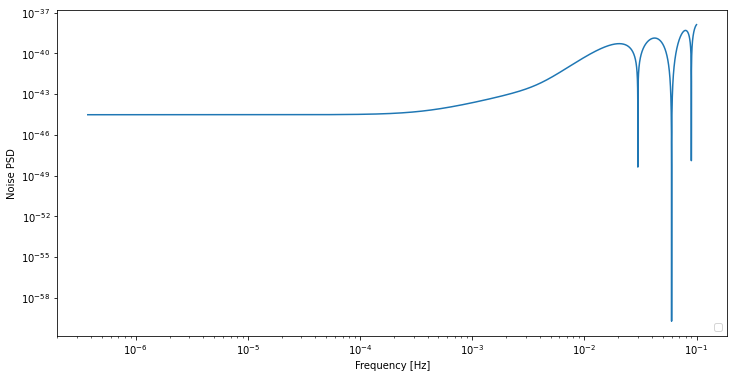

In [18]:
plt.figure(figsize=(12,6))
plt.plot(f_dft[id_pos], s_n)
plt.legend(loc="lower right")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Noise PSD")
plt.xscale("log")
plt.yscale("log")
plt.show()

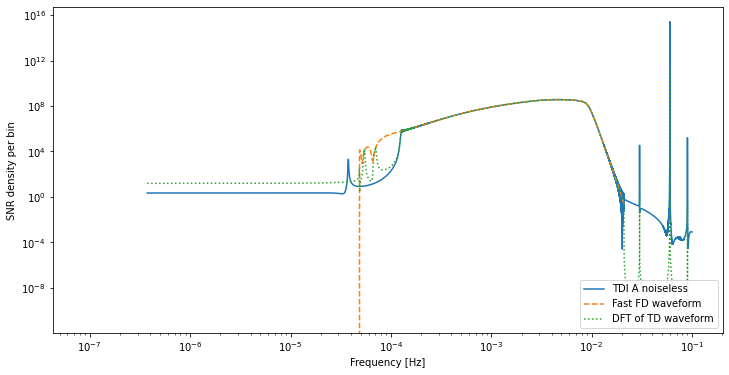

In [19]:
plt.figure(figsize=(12,6))
plt.plot(f_dft[id_pos], np.abs(a_dft[id_pos])**2/s_n, 
         label="TDI A noiseless")
plt.plot(af.f[af.f>0], np.abs(af.values[af.f>0])**2/s_n_f, 
         label="Fast FD waveform", 
         linestyle='dashed')
plt.plot(f_dft[id_pos], np.abs(a_t_dft[id_pos])**2/s_n, 
         label="DFT of TD waveform", 
         linestyle='dotted')
plt.legend(loc="lower right")
plt.xlabel("Frequency [Hz]")
plt.ylabel("SNR density per bin")
plt.xscale("log")
plt.yscale("log")
plt.show()

Computation of the SNR my way: we know that if $\tilde{x}$ is the FFT of $x$, then the expectation of the periodogram is equal to the PSD:

$$
P_{x}(f) \equiv \operatorname{E}\left[\frac{2 \lvert \tilde{x} \rvert^{2}}{f_s N}\right] = S_{n}(f)
$$

where $S_{n}(f)$ is the one-sided PSD of the noise. Therefore, the SNR is given by

$$
\rho^{2} = \sum_{k=k_{\min}}^{k_{\max}} \frac{P_{x}(f_k) + P_{x}(-f_k)}{S_{n}(f_k)} = \sum_{k=k_{\min}}^{k_{\max}} \frac{2 P_{x}(f_k)}{S_{n}(f_k)}
$$

where $f_k = k f_s / N$ are the Fourier frequencies.

In [20]:
# We need to restrict the frequency band
fmin = 1e-5
fmax = af.f.values[-1]
id_keep = np.where((f_dft>=1e-5) & (f_dft <= fmax))[0]
# PSD computed on Fourier grid
s_n = func(f_dft[id_keep])
# Using the DFT of the time-domain waveform
paf_dft = 2 * np.abs(a_t_dft[id_keep]/dt)**2 / (size * fs)
snr2 = np.sum(2 * paf_dft / s_n)
print(np.sqrt(snr2))
# Using the DFT of the simulated noiseless data
paf_dft = 2 * np.abs(a_dft[id_keep]/dt)**2 / (size * fs)
snr2 = np.sum(2 * paf_dft/ s_n)
print(np.sqrt(snr2))

3090.687869710456
3077.5861412239146


It seems there is a bit more power in the simulated noiseless data. If we look at the plot above, there are indeed more features at low and high frequencies, even in the restricted region. We have to be careful about that when we work in the time domain.

If we use the ugly formula

$$
\mathrm{SNR}^2 = 4 \Re \int_{f_{\min}}^{f_{\max}} \frac{\lvert h(f) \rvert^{2}}{S_{n}(f)} df
$$

where $h(f)$ is the continuous Fourier transform of the source and $S_n(f)$ is the one-sided PSD.

In [21]:
# Using the frequency-domain waveform
s_n_f = func(af.f.values[af.f>0])
h_f = af.values[af.f>0]
df = af.f.values[2] - af.f.values[1]
snr2 = 4 * df * np.sum(np.abs(h_f)**2 / s_n_f)
print(np.sqrt(snr2))

3090.698408849283


The continuous formula gives more SNR, probably because of the extra power at low frequency in the approximated waveform. We should  

## 4 Computing SNR in the time domain

Now we consider the signal in the time domain $x(t)$. If $C$ is the covariance matrix of the noise in the time domain, we should have

$$
\rho^{2} = x^{T} C^{-1} x
$$

The time-domain covariance is related to the PSD by

$$
C(n, m) = \frac{1}{2} \int_{-f_s / 2}^{+ f_s / 2} S_{n}(f) e^{2 \pi i f (n-m) \tau_s} df
$$

if $S_{n}(f)$ is still the one-sided PSD.

The matrix $C$ is Toeplitz, so we can solve the Toeplitz system $C u = x$ by using adapted algorithms. Let's try it.

In [22]:
from bayesdawn import datamodel, psdmodel
from bayesdawn import algebra

We modify the PSD so that we keep some power at high frequencies and avoid the dips. Otherwise it would be equivalent of keeping the spikes we see above 1e-2 Hz in the SNR-per-bin plot. Maybe anotherway would be to filter the high frequencies in the autocovariance...

In [24]:
# The time-domain waveform we consider
h_t = at[-size:].values
# Let's re-scale everything (h and PSD) by the norm of h.
scale = LA.norm(h_t)
h_t = h_t / scale

In [25]:
# Embed the PSD function in a class
class MyPSD(psdmodel.PSD):

    def __init__(self, n_data, fs):

        psdmodel.PSD.__init__(self, n_data, fs, fmin=None, fmax=None)

    def psd_fn(self, x):

        sn = np.zeros(x.size)
        sn[(x<=fmax) & (x>=fmin)] = func(x[(x<=fmax) & (x>=fmin)])
        sn[x>fmax] = func(fmax)
        sn[x<fmin] = func(fmin)

        return sn / scale**2

In [27]:
s = np.zeros(size)
mask = np.ones(size)
psd_cls = MyPSD(size, fs)
imp_cls = datamodel.GaussianStationaryProcess(s, mask, psd_cls, method='PCG')

Time series does not contain gaps.


In [28]:
# Compute the autocovariance
imp_cls.compute_offline()
# Compute the preconditionner
imp_cls.compute_preconditioner()

Computation of autocovariance + PSD took 0.10354304313659668
Build preconditionner...
Preconditionner built.


/var/folders/_5/n0nmrdh5083fp_sk92symhbj8pm2pl/T/ipykernel_19633/1487163909.py:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(np.arange(imax) * dt, imp_cls.autocorr[0:imax], use_line_collection=True)


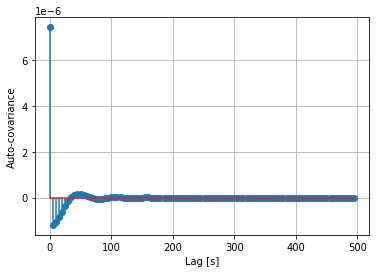

In [29]:
plt.figure(0)
imax = 100
plt.stem(np.arange(imax) * dt, imp_cls.autocorr[0:imax], use_line_collection=True)
plt.xlabel('Lag [s]')
plt.ylabel('Auto-covariance')
plt.grid(True)
plt.show()

In [30]:
# Compute the one-sided PSD on a 2N grid:
f2 = np.fft.fftfreq(2 * size) * fs
s_2n = psd_cls.psd_fn(np.abs(f2))

In [31]:
# Now compute C^{-1} x
inds_obs = np.arange(size)
# First guess
x0 = np.zeros(size)
# Stopping criterium
tol = imp_cls.tol
# Maximum number of iterations
maxiter = 5000
# Chosen algorithm
pcg_algo = 'mine'
# Solve the Toeplitz system
u, info = algebra.matrixalgebra.pcg_solve(inds_obs, mask, s_2n, 
                                          h_t, 
                                          x0, tol, 
                                          maxiter, 
                                          imp_cls.solve, 
                                          pcg_algo)

PCG Iteration 20 completed
Residuals = 0.005932394243934506 compared to criterion = 1e-06
PCG Iteration 40 completed
Residuals = 6.09807627818334e-05 compared to criterion = 1e-06
Preconditioned BiCGSTAB algorithm ended with:
45iterations.


In [32]:
# Test if the solver worked
coo_op = algebra.matrixalgebra.cov_linear_op(inds_obs, inds_obs, mask, s_2n)
# Apply C to u
x_est = coo_op(u)

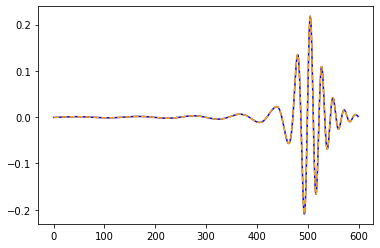

In [33]:
i1 = int(5.25e5)
i2 = int(5.256e5)
plt.figure(0)
plt.plot(x_est[i1:i2], label="Estimate", color='blue')
plt.plot(h_t[i1:i2], label="Truth", color='orange', linestyle='dashed')
plt.show()

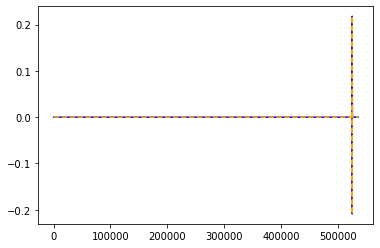

In [34]:
plt.figure(0)
plt.plot(x_est[:], label="Estimate", color='blue')
plt.plot(h_t[:], label="Truth", color='orange', linestyle='dashed')
plt.show()

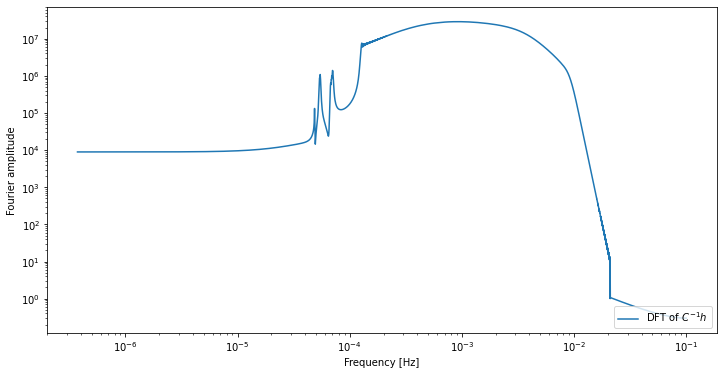

In [35]:
# Let's see how much power there is at high frequencies in u
u_fft = fft(u)
plt.figure(figsize=(12,6))
plt.plot(f_dft[id_pos], np.abs(u_fft[id_pos]), 
         label=r"DFT of $C^{-1} h$")
plt.ylabel("Fourier amplitude")
plt.legend(loc="lower right")
plt.xlabel("Frequency [Hz]")
plt.xscale("log")
plt.yscale("log")
plt.show()

Now let's compute 

$$
\rho^{2} = x^{T} C^{-1} x
$$

In [36]:
snrs = h_t * u
snr2_time = np.sum(snrs[:])
print(np.sqrt(snr2_time))

977.361319446035


## 5 Verifications

In [38]:
from scipy import sparse

In [40]:
# Check why Scipy does not 
p_op = algebra.matrixalgebra.precond_linear_op(imp_cls.solve, size, size)
tol_eff = np.min([tol, tol * LA.norm(h_t)])

In [41]:
class CallBack:

    def __init__(self):

        self.i = 0
    
    def callback(self, xk):

        self.i += 1
        if self.i % 10 == 0:
            print(self.i)

In [42]:
cb = CallBack()
u, info = sparse.linalg.bicgstab(coo_op, h_t, 
                                 x0=x0, 
                                 tol=tol_eff,
                                 maxiter=100, 
                                 M=p_op,
                                 callback=cb.callback)
algebra.matrixalgebra.print_pcg_status(info)

10
20
30
successful exit!


In [43]:
# Apply C to u
x_est_scipy = coo_op(u)

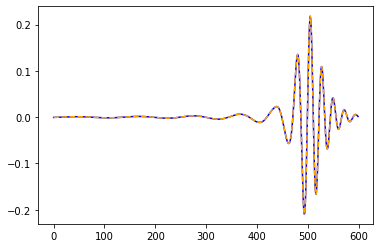

In [44]:
plt.figure(0)
plt.plot(x_est_scipy[i1:i2], label="Estimate", color='blue')
plt.plot(h_t[i1:i2], label="Truth", color='orange', linestyle='dashed')
plt.show()

In [45]:
snr2_time = np.sum(h_t * u)
print(np.sqrt(snr2_time))

977.3612757258123


## 6 Dependence on stopping criterium

In [ ]:
cb = CallBack()
u, info = sparse.linalg.bicgstab(coo_op, h_t, 
                                 x0=x0, 
                                 tol=tol_eff/10,
                                 maxiter=200, 
                                 M=p_op,
                                 callback=cb.callback)
algebra.matrixalgebra.print_pcg_status(info)

In [ ]:
snr2_time = np.sum(h_t * u)
print(np.sqrt(snr2_time))